In [1]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
# Timing function for performance evaluation
import time
class catchtime:    
    def __init__(self, arg = 'Unnamed Context'):
#         print('__init__ called with', arg)
        self.context = arg
        
    def __enter__(self):
        self.time = time.perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        self.time = time.perf_counter() - self.time
        self.readout = f'{self.context} took: {1000 * self.time:.3f} ms'
        print(self.readout)

# Math/parallelization library includes
import numpy as np
import torch

# Imports for neighborhood searches later on
from torch_geometric.nn import radius
from torch_scatter import scatter

# TQDM is used for rendering progress bars
from tqdm.notebook import trange, tqdm

# Plotting includes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import matplotlib.tri as tri
import random

# Set plotting mode to correct setting for Jupyter Notebook
%matplotlib notebook

In [2]:
# For computational efficiency we now restate the kernel function as only depending on the radial distance 
# as recomputing the distance of two points for every single interpolation is a significant waste of resources 
# and redundant. Note that this, in practice, is not always possible due to memory considerations. 
# Accordingly, this function is now called with a set of distances instead of a single pair of positions.
# This also means that we move the bounds check out of the function
C = 5/4
def wendland2(q, support):
    return C * (1-q)**3 * (1 + 3 * q) / (support)

def gradWendland2(q, dist, support):
    return -dist * C * 12 * (q-1)**2 * q / (support ** 2)

In [3]:
# Particle properties
baseArea = 0.125
particleRadius = baseArea / 2.0
particleSupport = particleRadius * 8.

# Fluid properties
kappa = 1.5
restDensity = 1000.
dt = 1e-2

# Domain properties
spacingOuter = particleRadius * 1.0
spacingInner = spacingOuter * 0.5
innerWidth = 5.
minDomain = -20
maxDomain = 20

In [4]:
# Plotting function for convenience
def plot1DValues(x,counts, scatter = False, xlabel = None, ylabel = None, title = None):
    if scatter:
        x = x
        y = np.zeros_like(x)
        c = counts

        fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
        sc = axis[0,0].scatter(x, y, c = c, s = 1)
        ax1_divider = make_axes_locatable(axis[0,0])
        cax1 = ax1_divider.append_axes("bottom", size="20%", pad="2%")
        cb1 = fig.colorbar(sc, cax=cax1,orientation='horizontal')
        cb1.ax.tick_params(labelsize=8) 
        axis[0,0].axvline(minDomain, color = 'black', ls = '--')
        axis[0,0].axvline(maxDomain, color = 'black', ls = '--')
        
        if not xlabel is None:
            axis[0,0].set_xlabel(xlabel)
        if not ylabel is None:
            cb1.ax.set_xlabel(ylabel)        
        if not title is None:
            fig.suptitle(title)
        
        fig.tight_layout()
        
    else:
        x = x
        y = counts
        idx = np.argsort(x)

        fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
        axis[0,0].plot(x[idx], y[idx])
        axis[0,0].axvline(minDomain, color = 'black', ls = '--')
        axis[0,0].axvline(maxDomain, color = 'black', ls = '--')
        
        if not xlabel is None:
            axis[0,0].set_xlabel(xlabel)
        if not ylabel is None:
            axis[0,0].set_ylabel(ylabel)
        if not title is None:
            fig.suptitle(title)
        fig.tight_layout()

In [9]:
# Same concept as before, just now moved to a separate function for legibility
def createGhostParticles(particles):
    ghostParticlesLeft = particles - (maxDomain - minDomain)
    ghostParticlesRight = particles + (maxDomain - minDomain)

    allParticles = torch.hstack((ghostParticlesLeft, particles, ghostParticlesRight))
    return allParticles

def findNeighborhoods(particles, allParticles, support):
    # Call the external neighborhood search function
    row, col = radius(allParticles, particles, support, max_num_neighbors = 256)
    fluidNeighbors = torch.stack([row, col], dim = 0)
        
    # Compute the distances of all particle pairings
    fluidDistances = (allParticles[fluidNeighbors[1]] - particles[fluidNeighbors[0]])
    # This could also be done with an absolute value function
    fluidRadialDistances = torch.abs(fluidDistances)# torch.sqrt(fluidDistances**2)

    # Compute the direction, in 1D this is either 0 (i == j) or +-1 depending on the relative position
    fluidDistances[fluidRadialDistances < 1e-7] = 0
    fluidDistances[fluidRadialDistances >= 1e-7] /= fluidRadialDistances[fluidRadialDistances >= 1e-7]
    fluidRadialDistances /= support
    
    # Modify the neighbor list so that everything points to the original particles
    particleIndices = torch.arange(particles.shape[0])
    stackedIndices = torch.hstack((particleIndices, particleIndices, particleIndices))
    fluidNeighbors[1,:] = stackedIndices[fluidNeighbors[1,:]]    
    
    return fluidNeighbors, fluidRadialDistances, fluidDistances
def computeDensity(particles, particleArea, fluidRadialDistances, fluidNeighbors):
    pairWiseDensity = particleArea[fluidNeighbors[1]] * wendland2(fluidRadialDistances, particleSupport)
    fluidDensity = scatter(pairWiseDensity, fluidNeighbors[0], dim=0, dim_size = particles.shape[0],reduce='add')
    
    return fluidDensity

In [22]:
pl = torch.arange(minDomain,-innerWidth, spacingOuter )
pc = torch.arange(-innerWidth,innerWidth, spacingOuter)
pr = torch.arange(innerWidth,maxDomain, spacingOuter )

fluidPositions = torch.hstack((pl,pc,pr))
fluidVelocities = torch.zeros(fluidPositions.shape[0])
fluidAreas = torch.normal(mean = torch.ones_like(fluidPositions) * baseArea, std = torch.ones_like(fluidPositions) * 0.01)

# print(particleArea)

<IPython.core.display.Javascript object>


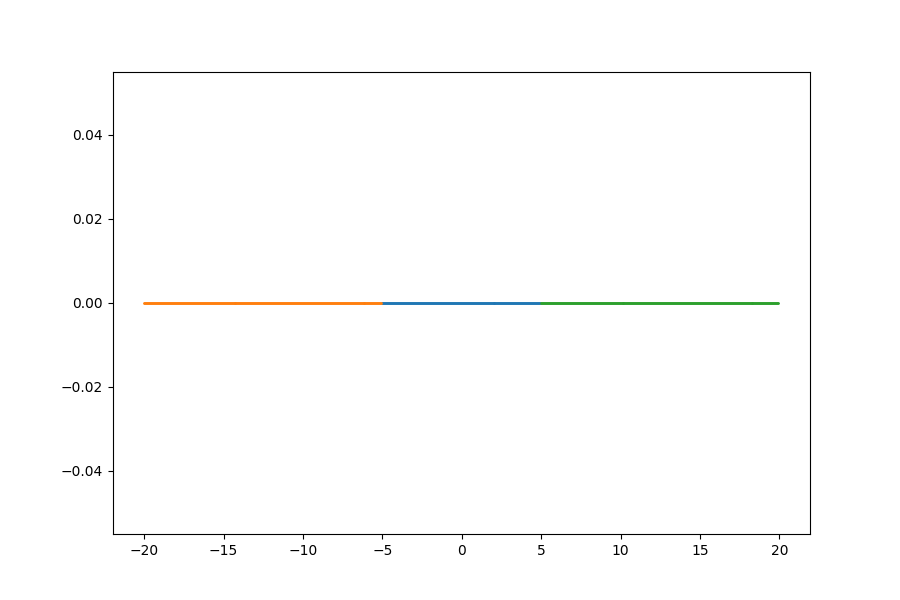

In [23]:
fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
axis[0,0].scatter(pc,torch.zeros_like(pc),s=1)
axis[0,0].scatter(pl,torch.zeros_like(pl),s=1)
axis[0,0].scatter(pr,torch.zeros_like(pr),s=1);

In [24]:
ghostPositions = createGhostParticles(fluidPositions)
fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
fluidDensity = computeDensity(fluidPositions, fluidAreas, fluidRadialDistances, fluidNeighbors)

<IPython.core.display.Javascript object>


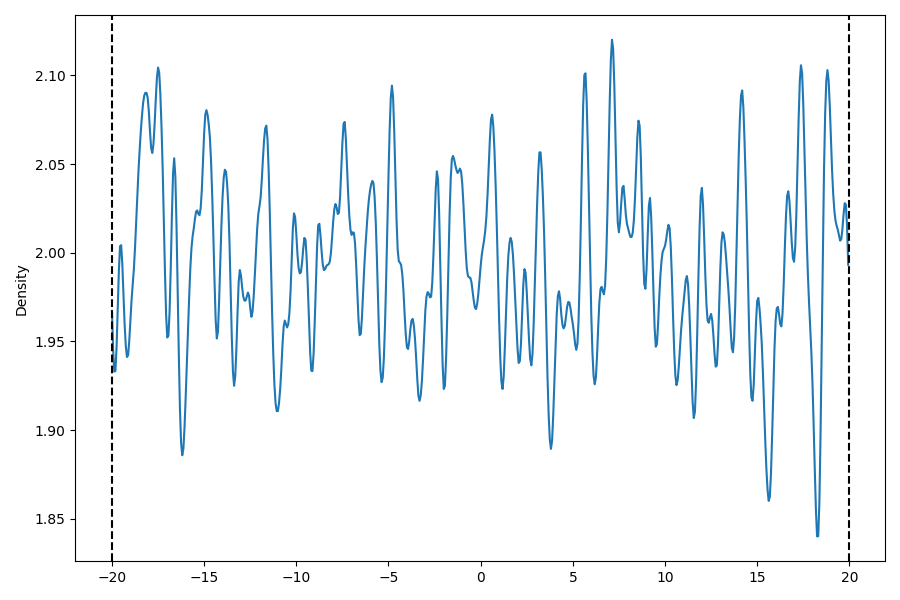

In [25]:
# indices, counts = torch.unique(fluidNeighbors[0,:], return_counts = True)
# plot1DValues(fluidPositions[indices], counts[indices], ylabel = 'Neighbors')
plot1DValues(fluidPositions, fluidDensity, ylabel = 'Density')

In [26]:
fluidPressure = (fluidDensity - 1.0) * kappa * restDensity

In [324]:
def computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, fluidNeighbors, fluidRadialDistances, fluidDistances):
    i = fluidNeighbors[0,:]
    j = fluidNeighbors[1,:]

    pairwisePressureForces = fluidAreas[j] * \
            (fluidPressure[i] / fluidDensity[i]**2 + fluidPressure[j] / fluidDensity[j]**2) *\
            gradWendland2(fluidRadialDistances, fluidDistances, particleSupport)
    fluidPressureForces = scatter(pairwisePressureForces, fluidNeighbors[0], dim=0, dim_size = fluidPositions.shape[0],reduce='add')
    
    return fluidPressureForces

In [28]:
fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, fluidNeighbors, fluidRadialDistances, fluidDistances)

In [62]:
xsphConstant = 0.5 # We do not want 'real' viscosity, just a minor diffusion term for stability

def computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, fluidNeighbors, fluidRadialDistances):
    i = fluidNeighbors[0,:]
    j = fluidNeighbors[1,:]

    pairwiseXSPH = xsphConstant * fluidAreas[j] / ( fluidDensity[i] + fluidDensity[j]) * 2 \
                * (fluidVelocities[j] - fluidVelocities[i]) \
                * wendland2(fluidRadialDistances, particleSupport) 
    
    xsphUpdate = scatter(pairwiseXSPH, fluidNeighbors[0], dim=0, dim_size = fluidPositions.shape[0],reduce='add')
    
    return xsphUpdate

In [64]:
# Particle properties
baseArea = 0.125
particleRadius = baseArea / 2.0
particleSupport = particleRadius * 8.

# Fluid properties
kappa = 1.5
restDensity = 10.
dt = 1e-2

# Domain properties
spacingOuter = particleRadius * 1.0
spacingInner = spacingOuter * 0.5
innerWidth = 5.
minDomain = -20
maxDomain = 20

# Generate particles as usual
pl = torch.arange(minDomain,-innerWidth, spacingOuter )
pc = torch.arange(-innerWidth,innerWidth, spacingOuter)
pr = torch.arange(innerWidth,maxDomain, spacingOuter )

fluidPositions = torch.hstack((pl,pc,pr))
fluidVelocities = torch.zeros(fluidPositions.shape[0])
fluidAreas = torch.normal(mean = torch.ones_like(fluidPositions) * baseArea, std = torch.ones_like(fluidPositions) * 0.01)
fluidAreas = torch.ones_like(fluidPositions) * baseArea + torch.sin(fluidPositions / 20 * np.pi) * baseArea * 0.5

# For plotting and analysis we store the state of all particles in all timesteps so we can look at anything
# that we are interested in after the simulation has been run
simulationStates = []

for i in tqdm(range(2048)):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    #  3. Compute \rho using an SPH interpolation
    fluidDensity = computeDensity(fluidPositions, fluidAreas, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, fluidNeighbors, fluidRadialDistances)
    fluidVelocities += xsphUpdate
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces / (particleArea * restDensity)
    #  7. Store the current simulation state before time integration
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, fluidAccel]))
    #  8. Euler integration of velocities and positions
    fluidVelocities += dt * fluidAccel
    fluidPositions += dt * fluidVelocities
    #  9. Enforce boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
    # 10. Resort data for convenience
    indices = torch.argsort(fluidPositions)
    fluidPositions = fluidPositions[indices]
    fluidVelocities = fluidVelocities[indices]
    fluidAreas = fluidAreas[indices]
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/2048 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


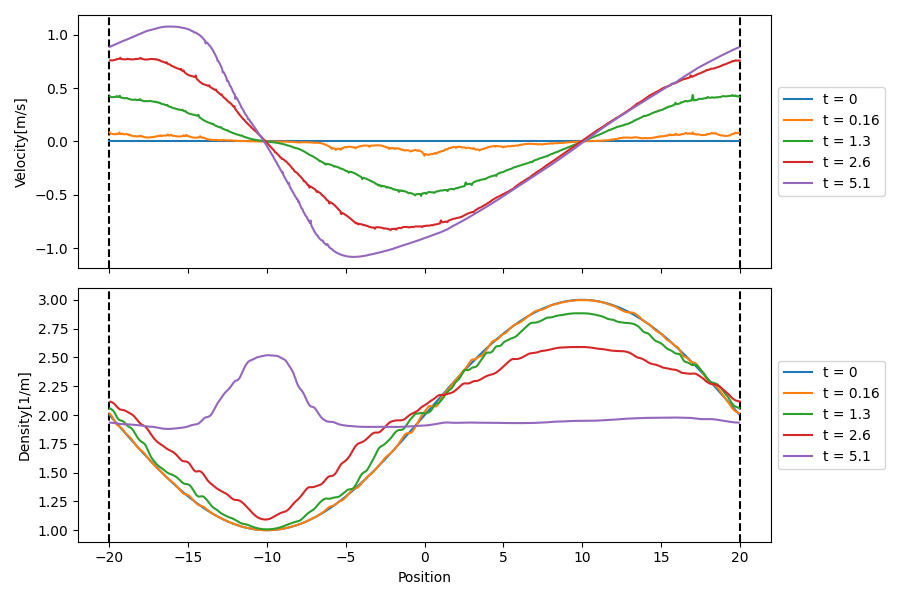

In [65]:
fig, axis = plt.subplots(2, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)

axis[0,0].axvline(minDomain, color = 'black', ls = '--')
axis[0,0].axvline(maxDomain, color = 'black', ls = '--')
axis[1,0].axvline(minDomain, color = 'black', ls = '--')
axis[1,0].axvline(maxDomain, color = 'black', ls = '--')

axis[1,0].set_xlabel('Position')
axis[0,0].set_ylabel('Velocity[m/s]')
axis[1,0].set_ylabel('Density[1/m]')

def plotTimePoint(i, c, simulationStates, axis):
    x = simulationStates[i,0,:]
    y = simulationStates[i,c,:]
    idx = torch.argsort(x)
    axis.plot(x[idx], y[idx], label = 't = %1.2g' % (i * dt))
    
plotTimePoint(0,1, simulationStates, axis[0,0])
plotTimePoint(0,2, simulationStates, axis[1,0])

plotTimePoint(16,1, simulationStates, axis[0,0])
plotTimePoint(16,2, simulationStates, axis[1,0])

plotTimePoint(128,1, simulationStates, axis[0,0])
plotTimePoint(128,2, simulationStates, axis[1,0])

plotTimePoint(256,1, simulationStates, axis[0,0])
plotTimePoint(256,2, simulationStates, axis[1,0])

plotTimePoint(511,1, simulationStates, axis[0,0])
plotTimePoint(511,2, simulationStates, axis[1,0])


axis[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axis[1,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

<IPython.core.display.Javascript object>


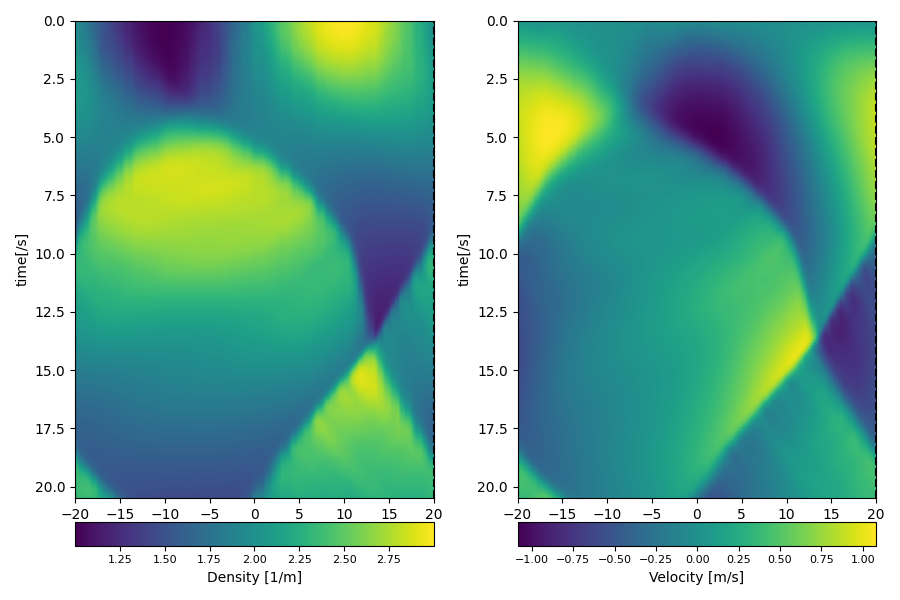

In [66]:
fig, axis = plt.subplots(1, 2, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

im = axis[0,0].imshow(simulationStates[:,2], extent = [minDomain,maxDomain,dt * simulationStates.shape[0],0])
axis[0,0].set_aspect('auto')
axis[0,0].set_ylabel('time[/s]')
axis[0,0].set_xlabel('pseudo-position')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="5%")
cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
cb1.ax.tick_params(labelsize=8) 
axis[0,0].axvline(minDomain, color = 'black', ls = '--')
axis[0,0].axvline(maxDomain, color = 'black', ls = '--')
cb1.ax.set_xlabel('Density [1/m]')


im = axis[0,1].imshow(simulationStates[:,1], extent = [minDomain,maxDomain,dt * simulationStates.shape[0],0])
axis[0,1].set_aspect('auto')
axis[0,1].set_ylabel('time[/s]')
axis[0,1].set_xlabel('pseudo-position')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="5%")
cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
cb1.ax.tick_params(labelsize=8) 
axis[0,1].axvline(minDomain, color = 'black', ls = '--')
axis[0,1].axvline(maxDomain, color = 'black', ls = '--')
cb1.ax.set_xlabel('Velocity [m/s]')

fig.tight_layout()

In [74]:

import scipy
import seaborn as sns

<IPython.core.display.Javascript object>


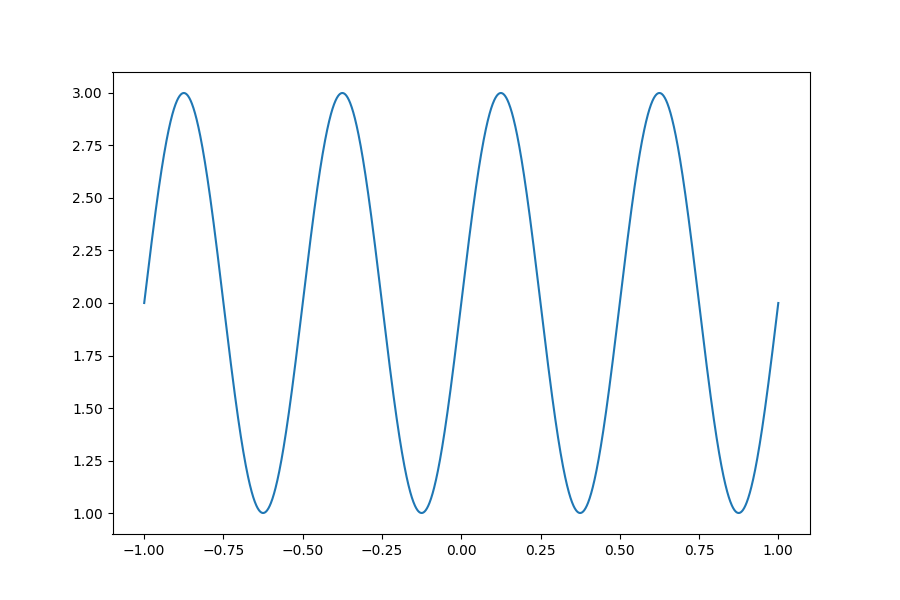

In [428]:
x = np.linspace(-1,1,2048)

pdf = lambda x: np.sin(x * np.pi * 4) + 2
# def pdf(x):
#     out = np.array(np.ones_like(x) * 2)
#     out[np.abs(x) > 1/3] = 1
#     return out

fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

xs = np.linspace(-1,1,n)


axis[0,0].plot(xs, pdf(xs))


import scipy.integrate as integrate

integral, err = integrate.quad(pdf, -1, 1)

normalized_pdf = lambda x: pdf(x) / integral

n = 2048
cdf = []
for i in range(n):
#     cdf.append(i)
    cdf.append(integrate.quad(normalized_pdf, -1, -1 + i * 2 / (n-1))[0])
sampled_cdf = np.array(cdf)
sampled_pdf = normalized_pdf(np.linspace(-1,1,n))

cdf = lambda x : np.interp(x, np.linspace(-1,1,n), sampled_cdf)
inv_cdf = lambda x : np.interp(x, sampled_cdf, np.linspace(-1,1,n))

# fig, axis = plt.subplots(1, 2, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
# xs = np.linspace(-1,1,n)
# axis[0,0].plot(xs, cdf(xs))
# axis[0,1].plot(np.linspace(0,1,n), inv_cdf(np.linspace(0,1,n)))
# axis[0,1].plot(xs, normalized_pdf(xs))

ns = 640

samples = np.random.uniform(size = ns)
samples = np.linspace(0,1,ns)
sampled = inv_cdf(samples)

# fig, axis = plt.subplots(1, 2, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
# axis[0,0].scatter(sampled, sampled * 0, s = 1)

In [429]:
# 

<IPython.core.display.Javascript object>


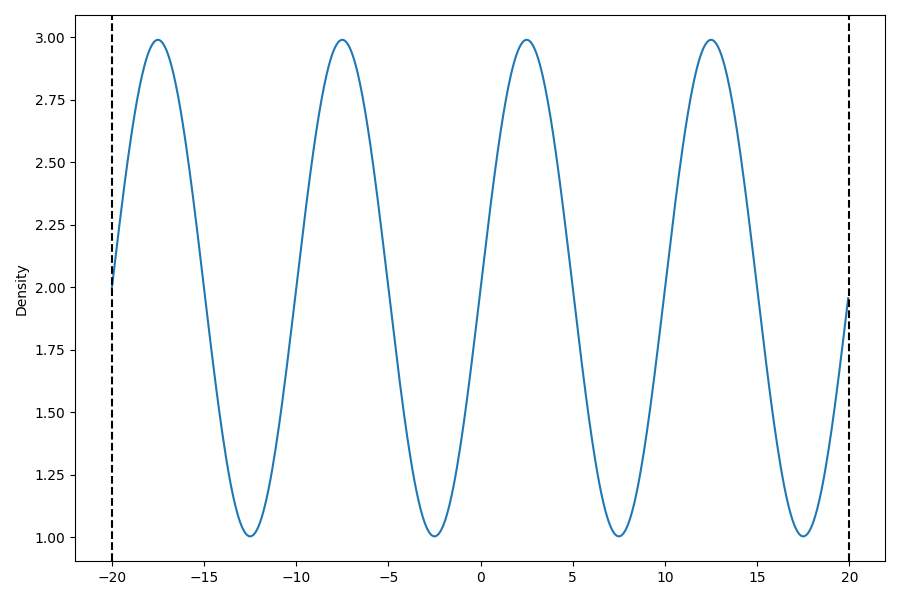

torch.Size([639])

In [430]:
# Particle properties
baseArea = 0.125
particleRadius = baseArea / 2.0
particleSupport = particleRadius * 8.
xsphConstant = 0.01
# Fluid properties
kappa = 1.5
restDensity = 10.
dt = 1e-2

# Domain properties
spacingOuter = particleRadius * 1.0
spacingInner = spacingOuter * 0.5
innerWidth = 5.
minDomain = -20
maxDomain = 20

xsphConstant = 0.01

# Generate particles as usual
pl = torch.arange(minDomain,-innerWidth, spacingOuter )
pc = torch.arange(-innerWidth,innerWidth, spacingOuter)
pr = torch.arange(innerWidth,maxDomain, spacingOuter )

# print(len(pl) + len(pc)+len(pr))

fluidPositions = torch.hstack((pl,pc,pr))
fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain)[:-1]
fluidVelocities = torch.zeros(fluidPositions.shape[0])
fluidAreas = torch.normal(mean = torch.ones_like(fluidPositions) * baseArea, std = torch.ones_like(fluidPositions) * 0.01)
fluidAreas = torch.ones_like(fluidPositions) * baseArea + torch.sin(fluidPositions / 20 * np.pi) * baseArea * 0.5
fluidAreas = torch.ones_like(fluidPositions) * baseArea

# For plotting and analysis we store the state of all particles in all timesteps so we can look at anything
# that we are interested in after the simulation has been run
simulationStates = []

    #  1. Create ghost particles for our boundary conditions
ghostPositions = createGhostParticles(fluidPositions)
#  2. Find neighborhoods of all particles:
fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
#  3. Compute \rho using an SPH interpolation
fluidDensity = computeDensity(fluidPositions, fluidAreas, fluidRadialDistances, fluidNeighbors)

# indices, counts = torch.unique(fluidNeighbors[0,:], return_counts = True)
# plot1DValues(fluidPositions[indices], counts[indices], ylabel = 'Neighbors')
plot1DValues(fluidPositions, fluidDensity, ylabel = 'Density')

fluidPositions.shape

In [431]:
def computeUpdate(fluidPositions, fluidVelocities, fluidAreas, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    #  3. Compute \rho using an SPH interpolation
    fluidDensity = computeDensity(fluidPositions, fluidAreas, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, fluidNeighbors, fluidRadialDistances)
#     fluidVelocities += xsphUpdate
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces / (fluidAreas * restDensity)
    #  7. Store the current simulation state before time integration
#     simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, fluidAccel]))
    #  8. Euler integration of velocities and positions
#     fluidVelocities += dt * fluidAccel
#     fluidPositions += dt * fluidVelocities
    
    return fluidAccel + xsphUpdate / dt, fluidDensity, fluidPressure

In [432]:

# For plotting and analysis we store the state of all particles in all timesteps so we can look at anything
# that we are interested in after the simulation has been run
simulationStates = []

for i in tqdm(range(2048*4)):
    dudt, fluidDensity, fluidPressure = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, dt)
#     if i % 8 == 0:
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dudt, fluidAreas]))
    #  8. Euler integration of velocities and positions
    fluidVelocities += dt * dudt
    fluidPositions += dt * fluidVelocities
    #  9. Enforce boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
    # 10. Resort data for convenience
    indices = torch.argsort(fluidPositions)
    fluidPositions = fluidPositions[indices]
    fluidVelocities = fluidVelocities[indices]
    fluidAreas = fluidAreas[indices]
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/8192 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


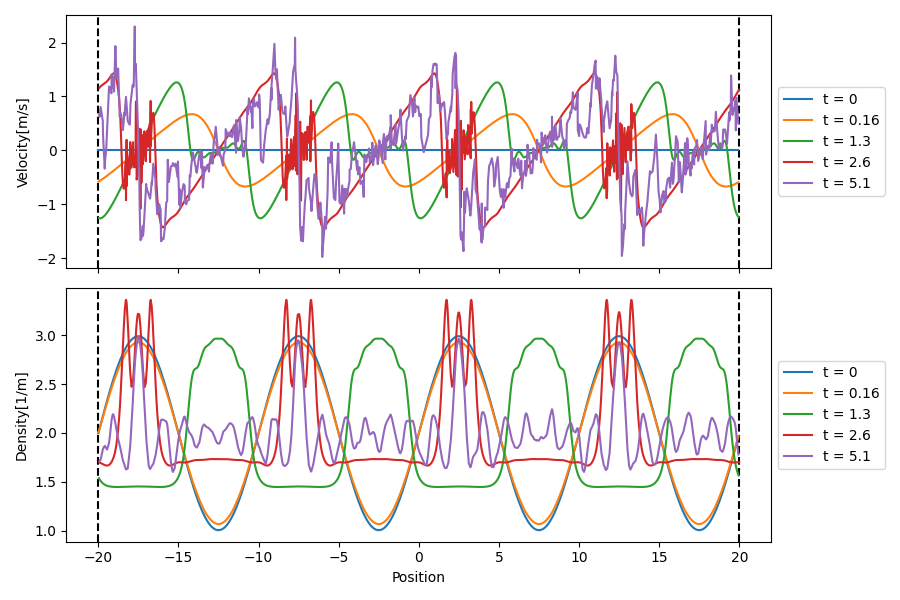

In [433]:
fig, axis = plt.subplots(2, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)

axis[0,0].axvline(minDomain, color = 'black', ls = '--')
axis[0,0].axvline(maxDomain, color = 'black', ls = '--')
axis[1,0].axvline(minDomain, color = 'black', ls = '--')
axis[1,0].axvline(maxDomain, color = 'black', ls = '--')

axis[1,0].set_xlabel('Position')
axis[0,0].set_ylabel('Velocity[m/s]')
axis[1,0].set_ylabel('Density[1/m]')

def plotTimePoint(i, c, simulationStates, axis):
    x = simulationStates[i,0,:]
    y = simulationStates[i,c,:]
    idx = torch.argsort(x)
    axis.plot(x[idx], y[idx], label = 't = %1.2g' % (i * dt))
    
plotTimePoint(0,1, simulationStates, axis[0,0])
plotTimePoint(0,2, simulationStates, axis[1,0])

plotTimePoint(16,1, simulationStates, axis[0,0])
plotTimePoint(16,2, simulationStates, axis[1,0])

plotTimePoint(128,1, simulationStates, axis[0,0])
plotTimePoint(128,2, simulationStates, axis[1,0])

plotTimePoint(256,1, simulationStates, axis[0,0])
plotTimePoint(256,2, simulationStates, axis[1,0])

plotTimePoint(511,1, simulationStates, axis[0,0])
plotTimePoint(511,2, simulationStates, axis[1,0])


axis[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axis[1,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

<IPython.core.display.Javascript object>


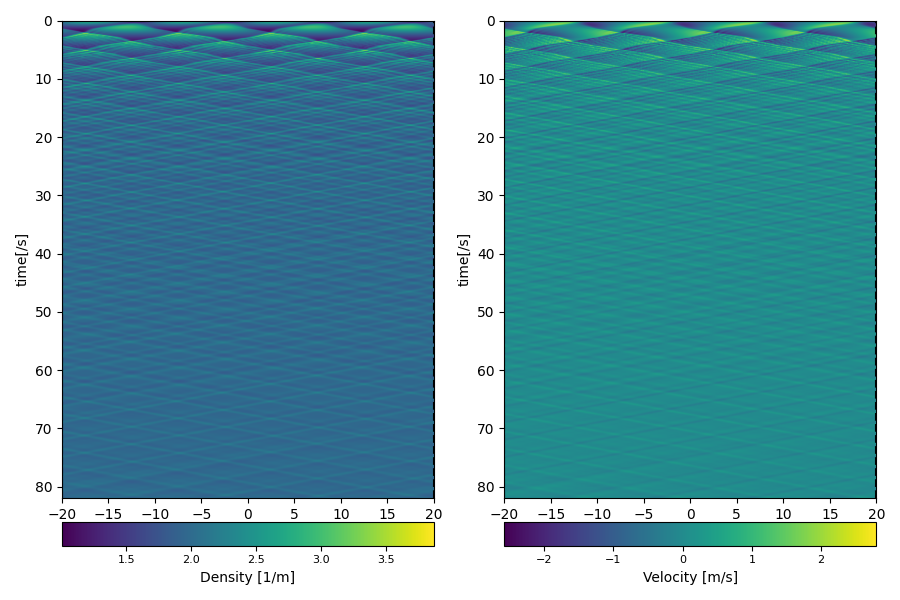

In [434]:
fig, axis = plt.subplots(1, 2, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

im = axis[0,0].imshow(simulationStates[:,2], extent = [minDomain,maxDomain,dt * simulationStates.shape[0],0])
axis[0,0].set_aspect('auto')
axis[0,0].set_ylabel('time[/s]')
axis[0,0].set_xlabel('pseudo-position')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="5%")
cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
cb1.ax.tick_params(labelsize=8) 
axis[0,0].axvline(minDomain, color = 'black', ls = '--')
axis[0,0].axvline(maxDomain, color = 'black', ls = '--')
cb1.ax.set_xlabel('Density [1/m]')


im = axis[0,1].imshow(simulationStates[:,1], extent = [minDomain,maxDomain,dt * simulationStates.shape[0],0])
axis[0,1].set_aspect('auto')
axis[0,1].set_ylabel('time[/s]')
axis[0,1].set_xlabel('pseudo-position')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="5%")
cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
cb1.ax.tick_params(labelsize=8) 
axis[0,1].axvline(minDomain, color = 'black', ls = '--')
axis[0,1].axvline(maxDomain, color = 'black', ls = '--')
cb1.ax.set_xlabel('Velocity [m/s]')

fig.tight_layout()

In [435]:
timeArray = torch.arange(simulationStates.shape[0])[:,None].repeat(1,simulationStates.shape[2]) * dt
positionArray = simulationStates[:,0]

# Random sampling can significantly reduce computational requirements but has significant visual artifacts
# n = 1024 * 64
# sampled = random.sample(range(timeArray.numel()), n)
sampled = range(timeArray.numel())

xSampled = positionArray.flatten()[sampled]
ySampled = timeArray.flatten()[sampled]
velSampled = simulationStates[:,2].flatten()[sampled]
densitySampled = simulationStates[:,1].flatten()[sampled]

triang = tri.Triangulation(xSampled, ySampled)

In [436]:
cm = plt.get_cmap('RdBu')
NUM_COLORS = 34
cols = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [437]:
fig, axis = plt.subplots(1, 2, figsize=(9,12), sharex = False, sharey = False, squeeze = False)

trip = axis[0,0].tripcolor(triang, velSampled, shading = 'gouraud', cmap = 'viridis')
axis[0,0].set_aspect('auto')
axis[0,0].set_ylabel('time[/s]')
axis[0,0].set_xlabel('position')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="5%")
cb1 = fig.colorbar(trip, cax=cax1,orientation='horizontal')
cb1.ax.tick_params(labelsize=8) 
axis[0,0].axvline(minDomain, color = 'black', ls = '--')
axis[0,0].axvline(maxDomain, color = 'black', ls = '--')
cb1.ax.set_xlabel('Density [1/m]')
axis[0,0].set_xlim(minDomain, maxDomain)
axis[0,0].set_ylim(simulationStates.shape[0] * dt, 0)


trip = axis[0,1].tripcolor(triang, densitySampled, shading = 'gouraud', cmap = 'RdBu', vmin = -torch.max(torch.abs(densitySampled)), vmax = torch.max(torch.abs(densitySampled)))
axis[0,1].set_aspect('auto')
axis[0,1].set_ylabel('time[/s]')
axis[0,1].set_xlabel('position')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="5%")
cb1 = fig.colorbar(trip, cax=cax1,orientation='horizontal')
cb1.ax.tick_params(labelsize=8) 
axis[0,1].axvline(minDomain, color = 'black', ls = '--')
axis[0,1].axvline(maxDomain, color = 'black', ls = '--')
cb1.ax.set_xlabel('Velocity [m/s]')
axis[0,1].set_xlim(minDomain, maxDomain)
axis[0,1].set_ylim(simulationStates.shape[0] * dt, 0)

fig.tight_layout()

<IPython.core.display.Javascript object>